Model unknown

  Variables:
    x : Size=72, Index={Kohle, GuD, Gasturbine}*{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
        Key                : Lower : Value              : Upper : Fixed : Stale : Domain
         ('Gasturbine', 0) :     0 : 40.325732899022796 :  None : False : False : NonNegativeReals
         ('Gasturbine', 1) :     0 : 26.319218241042336 :  None : False : False : NonNegativeReals
         ('Gasturbine', 2) :     0 : 14.136807817589556 :  None : False : False : NonNegativeReals
         ('Gasturbine', 3) :     0 : 214.88599348534194 :  None : False : False : NonNegativeReals
         ('Gasturbine', 4) :     0 : 223.65472312703582 :  None : False : False : NonNegativeReals
         ('Gasturbine', 5) :     0 : 115.26927252985881 :  None : False : False : NonNegativeReals
         ('Gasturbine', 6) :     0 :              300.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 7) :     0 :  260.2801302931596

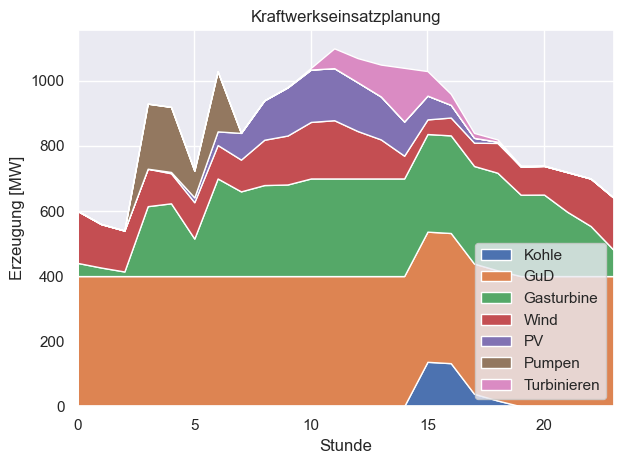

In [33]:


#Übung 3.3 a) Ziel dieser Aufgabe ist es den kostenminimalen Kraftwerkseinsatz und die Stromversorgungskosten sowie die Gesamtemissionen zu ermittelt. In dieser Aufgabe wird nun sowohl die Erzeugung von Erneuerbaren als auch Speicher in die Berechnung inkludiert.

#Einlesen der Module
from pyomo.environ import *
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


T = 24
timesteps = np.arange(T)

#Zertifikatspreis
c_CO2 = 80 # EUR/tCO2

# Marginal costs der thermischen Kraftwerke berechnen
# Werte wurden auf die Angabe angepasst
thermalPlant = ['Kohle', 'GuD', 'Gasturbine']
power = {'Kohle': 600,
         'GuD': 400,
         'Gasturbine': 300} # MW
efficiency = {'Kohle': 0.41,
         'GuD': 0.58,
         'Gasturbine': 0.4} 
fuel_price = {'Kohle': 10,
         'GuD': 30,
         'Gasturbine': 30} # EUR/MWhprim
emission_factor = {'Kohle': 0.35,
         'GuD': 0.2,
         'Gasturbine': 0.2} # tCO2/MWhprim
MC = {} # marginal costs in EUR/MWh
emissions = {} # emissions in tCO2/MWh
for n in thermalPlant:
    MC[n] = (fuel_price[n] + emission_factor[n] * c_CO2) / efficiency[n]
    emissions[n] = emission_factor[n] / efficiency[n]
    
# Daten laden, PV und Wind laden
df = pd.read_excel('Last_PV_Wind.xlsx')
wind = df['Wind 300 MW']
PV = df['PV 200 MW Sommer']
load = df['Last Sommer [MW]']

# Pyomo Modell aufstellen, es wurden Modelle für den Speicher hinzugefügt
# model.turb und model.pump für die Menge die gepumpt/turbiniert wird
# model.pump_dec sowie model.turb_dec stellen binäre decision Variablen dar, es wird entweder gepumpt/turbiniert oder nicht
# model.cap für die Menge die im Speicher drinnen ist

model = ConcreteModel()

model.x = Var(thermalPlant, timesteps, within = NonNegativeReals)
model.pump = Var(timesteps, within = NonNegativeReals) #Menge
model.turb = Var(timesteps, within = NonNegativeReals) #Menge
#model.pump_dec = Var(timesteps, within = pyo.Binary)#pumpen ja/nein
#model.turb_dec = Var(timesteps, within = pyo.Binary)#turbinieren ja/nein
model.cap = Var(timesteps, within = NonNegativeReals)#wie viel drin ist

#load = df['Last Sommer [MW]']#-df['Wind 300 MW']-df['PV 200 MW Sommer']#+model.pump[t]-model.turb[t]

# Zielfunktion, Kosten sollen minimiert werden
#dazu werden die Grenzkosten aller Kraftwerke zu jedem timestep summiert.
model.obj = Objective(
    expr = sum(model.x[n,t] * MC[n] for n in thermalPlant for t in timesteps), 
    sense= minimize)


#Nebenbedingungen bezüglich Leistung
def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
model.power_con = Constraint(thermalPlant, 
                             timesteps, 
                             rule = power_constraint_rule)

#Weitere Nebenbedingungen bzgl. Speicher: 

#entweder pumpen oder turbinieren oder keines davon
#def pump_turb_constraint_rule(model, t):
#    return model.pump_dec[t] + model.turb_dec[t] <= 1
#model.p_t = Constraint(timesteps,
#                               rule = pump_turb_constraint_rule)

#max Speicherkapazität darf nicht überschritten werden
def max_cap_constraint_rule(model, t):
    return model.cap[t] <= 600
model.max_cap = Constraint(timesteps,
                               rule = max_cap_constraint_rule)

#max Pumpkapazität darf nicht überschritten werden
def max_pump_constraint_rule(model, t):
    return model.pump[t] <= 200
model.max_pump = Constraint(timesteps,
                               rule = max_pump_constraint_rule)

#max Turbinierkapazität darf nicht überschritten werden
def max_turb_constraint_rule(model, t):
    return model.turb[t] <= 200
model.max_turb = Constraint(timesteps,
                               rule = max_turb_constraint_rule)

#es darf nicht mehr turbiniert werden als zur Verfügung steht
def max_turb1_constraint_rule(model, t):
    return model.turb[t] <= model.cap[t]/0.9
model.max_turb1 = Constraint(timesteps,
                               rule = max_turb1_constraint_rule)


#Kapziät bei t=23 muss gemäß Angabe gleich sein wie t=0
def capa_stand_constraint_rule(model, t):
    return model.cap[0] == model.cap[23]
model.cap1 = Constraint(timesteps,
                               rule = capa_stand_constraint_rule)

#Wie verändert sich capa beim pumpen/turbinieren johanna NB 
#def capa_constraint_rule(model, t):
 #   if t == 23:
 #       return model.cap[23] == model.cap[0]###########
 #   else:
 #       return model.cap[t+1] == model.cap[t] + model.pump[t] * model.pump_dec[t] * 0.9 - model.turb[t] * model.turb_dec[t]/ 0.9   
#model.capa = Constraint(timesteps, 
                  #          rule = capa_constraint_rule)

#probe neue NB 
def capa_constraint_rule(model, t):
    if t == 0:
       return model.cap[t] == 0
    else:
        return model.cap[t] <= model.cap[t-1] + model.pump[t]*0.9 - model.turb[t]/ 0.9   
model.capa = Constraint(timesteps, 
                           rule = capa_constraint_rule)


#NB ALEX FREUNDE
#def capa_constraint_rule(model, t):
 #   if t == 0:
  #      return model.cap[0] == 0 
  #  else:
  #      return model.cap[t] == model.cap[t-1] + model.pump[t] * model.pump_dec[t] * 0.9 - model.turb[t] * model.turb_dec[t]/ 0.9   
#model.capa = Constraint(timesteps, 
    #                    rule = capa_constraint_rule)


#neue Nebenbedingung gegenüber 3.1 und 3.2 bezüglich Last 
def load_constraint_rule(model, t):
   return (sum(model.x[n,t] for n in thermalPlant)) + wind.loc[t] + PV.loc[t] + model.turb[t] - model.pump[t] == load.loc[t] 
model.load_con = Constraint(timesteps, 
                            rule = load_constraint_rule)


###Schattenvariable###
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT_EXPORT)

opt = SolverFactory('gurobi')
opt_success = opt.solve(model)

model.display()

# get values of optimization variables
#PowerThermal = pd.DataFrame(index = timesteps, columns = thermalPlant)
#guDPower = np.empty(T, dtype=float)
#gasPower = np.empty(T, dtype=float)
#kohlePower = np.empty(T, dtype=float)
#pump = np.empty(T, dtype=float)
#turb = np.empty(T, dtype=float)
#for t in timesteps:
#    for n in thermalPlant:
#        PowerThermal.loc[t, n] = model.x[n,t].value
#        guDPower[t] = PowerThermal.loc[t, 'GuD']
#        gasPower[t] = PowerThermal.loc[t, 'Gasturbine']
#        kohlePower[t] = PowerThermal.loc[t, 'Kohle']
#        pump[t]=model.pump[t].value
#        turb[t]=model.turb[t].value


# get values of optimization variables
PowerThermal = pd.DataFrame(index = timesteps, columns = thermalPlant)
for t in timesteps:
    for n in thermalPlant:
        PowerThermal.loc[t, n] = model.x[n,t].value

print()
totalMinCost = model.obj()
print("Gesamtkosten der Stromversorgung:", totalMinCost, "EUR" )
totalEmissions = sum(model.x[n,t].value * emissions[n] for n in thermalPlant for t in timesteps)
print("Gesamte CO2 Emissionen", totalEmissions, "tCO2" )


# plot
values = pd.DataFrame(index=timesteps, columns=['pump','turb'])
for t in timesteps:
    values.loc[t,'pump'] = model.pump[t].value
    values.loc[t,'turb'] = model.turb[t].value

sns.set()
labels = ['Kohle', 'GuD', 'Gasturbine','Wind', 'PV','Pumpen','Turbinieren']

fig, ax = plt.subplots()

ax.stackplot(timesteps, 
            PowerThermal.to_numpy(dtype = float).transpose(),
             wind, PV,values['pump'].to_numpy(dtype = float).transpose(),
             values['turb'].to_numpy(dtype = float).transpose(),
             labels=labels)
ax.set_title('Kraftwerkseinsatzplanung')
ax.legend(loc='lower right')
ax.set_ylabel('Erzeugung [MW]')
ax.set_xlabel('Stunde')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()

for t in timesteps:
    print("turb", model.turb[t].value)
    print("pump", model.pump[t].value)
    print("capa", model.cap[t].value)
    print()

